## Cluster messy time series
Corinne Powers, PhD

Data Scientist

Retina AI

November 2019

In [1]:
import numpy as np
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

## Time series

In [2]:
def generate_truth(T):
    series1 = np.zeros(T)
    series1[:int(T/4)] = range(int(T/4))
    series1[int(T/4):int(T/2)-1] = range(int(T/4)-1)[::-1]
    series1 = series1/series1.max()

    series2 = np.sin(np.arange(T)/4)
    series2 = series2/series2.max()

    series3 = np.zeros(T)
    series3[1:int(T/2)]=1
    series3 = series3/series3.max()

    series4 = np.zeros(T)
    series4 = np.exp(-(np.arange(T)-(T/2.0))**2/(T/4)**2)
    series4 = series4/series4.max()

    series = [series1, series2, series3, series4]
    
    f, axes = plt.subplots(nrows=2, ncols=2)
    for i in range(2):
        for j in range(2):
            axes[i,j].plot(series[2*i+j])
            axes[i,j].axis('off')
    f.savefig("figures/truth", dpi=600)
    return series

In [3]:
def generate_data(T, m, noise_level):
    A = np.zeros((m,T))
    labels = np.random.choice(range(4), size=m, replace=True)
    for i in range(m):
        noise = np.random.normal(size=T)*noise_level
        A[i,:] = series[labels[i]]+noise 
    
    f, axes = plt.subplots(nrows=3, ncols=4)
    for i in range(3):
        for j in range(4):
            axes[i,j].plot(A[4*i+j, :])
            axes[i,j].axis('off')
    f.savefig("figures/simple_glimpse", dpi=600)
    
    f, axes = plt.subplots(nrows=8, ncols=3, figsize=(6,10))
    for i in range(8):
        for j in range(3):
            axes[i,j].plot(A[3*i+j, :])
            axes[i,j].axis('off')
    f.savefig("figures/simple_glimpse_big", dpi=600)
    return A

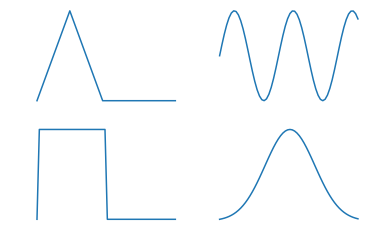

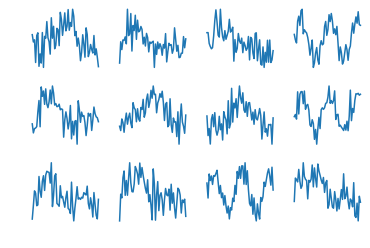

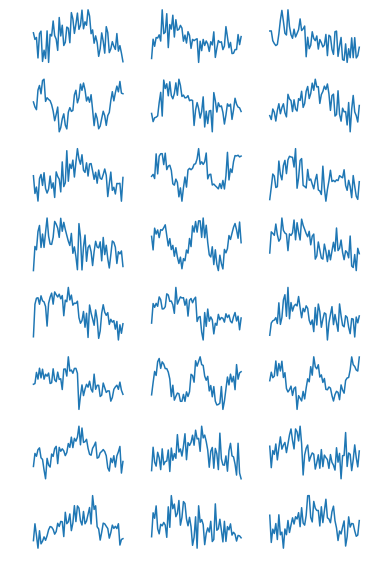

In [4]:
T = 60
m = 10000
noise = 0.4 # level
series = generate_truth(T) # k=4 by design
A = generate_data(T, m, noise)

## Cluster time series

In [5]:
def cluster_time_series(A):
    B = A.cumsum(axis=1)
    
    model = KMeans(n_clusters=4, random_state=0)
    model.fit(B)
    C = model.cluster_centers_
    
    C[:,1:] -= C[:,:-1].copy()
    
    f, axes = plt.subplots(nrows=2, ncols=2)
    for i in range(2):
        for j in range(2):
            axes[i,j].plot(C[2*i+j, :])
            axes[i,j].axis('off')
    f.savefig("figures/simple_cluster", dpi=600)
    return C, model.labels_

In [6]:
def impute_simple(A, C, labels, random_seed=1):
    B = np.vstack(C[l,:] for l in labels)
    
    f, axes = plt.subplots(nrows=3, ncols=4, sharex=True, sharey=True)
    for i in range(3):
        for j in range(4):
            axes[i,j].plot(A[4*i+j, :], alpha=0.3, color='k')
            axes[i,j].plot(B[4*i+j, :], alpha=1.0, color='b')
            axes[i,j].axis('off')
    f.savefig("figures/simple_glimpse_impute", dpi=600) 

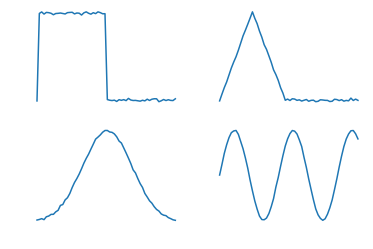

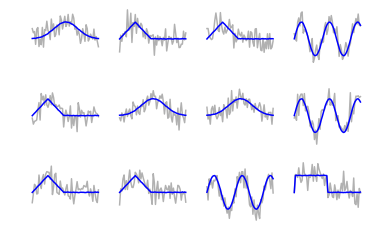

In [7]:
C, labels = cluster_time_series(A)
impute_simple(A, C, labels)

## Missing entries

In [8]:
def remove_entries(A, missing_samples, missing_series, sections=10, random_seed=1): 
    # remove (triangle-structured) missing entries (unknown futures)
    np.random.seed(random_seed)
    m, T = A.shape
    Z = A.copy()
    
    col_jump = int(T*missing_series/sections)
    row_jump = int(m*missing_samples/sections)
    to_remove_row = [m-(row_jump*(sections-i)) for i in range(sections)]
    to_remove_col = [T-(col_jump*(i+1)) for i in range(sections)]
    to_remove = list(zip(to_remove_row, to_remove_col))
    for i,j in to_remove:
        Z[i:,j:] = np.nan
        
    f, axes = plt.subplots(nrows=3, ncols=4, sharex=True, sharey=True)
    Y = Z.copy()
    np.random.shuffle(Y)
    for i in range(3):
        for j in range(4):
            axes[i,j].plot(Y[4*i+j, :])
            axes[i,j].axis('off')
    f.savefig("figures/missing_glimpse", dpi=600) 
    
    f, axes = plt.subplots(nrows=8, ncols=3, figsize=(6,10), sharex=True, sharey=True)
    for i in range(8):
        for j in range(3):
            axes[i,j].plot(Y[3*i+j, :])
            axes[i,j].axis('off')
    f.savefig("figures/missing_glimpse_big", dpi=60)
    return Z, to_remove

In [9]:
def cluster_substitute_mean(A):
    m, T = A.shape
    A_replace = A.copy()
    for j in range(T):
        A_replace[np.isnan(A_replace[:,j]), j] = np.nanmean(A_replace[:,j])
    B_replace = A_replace.cumsum(axis=1)
            
    model = KMeans(n_clusters=4, random_state=0)
    model.fit(B_replace)
    C_replace = model.cluster_centers_
    
    C_replace[:,1:] -= C_replace[:,:-1].copy()

    f, axes = plt.subplots(nrows=2, ncols=2)
    for i in range(2):
        for j in range(2):
            axes[i,j].plot(C_replace[2*i+j, :])
            axes[i,j].axis('off')
    f.savefig("figures/missing_experiment_replace", dpi=600)
    return C_replace

In [10]:
def cluster_exclude_missing(A):
    m, T = A.shape
    A_exclude = A.copy()
   
    A_exclude = A_exclude[(np.isnan(A_missing).sum(axis=1)==0),:]
    B_exclude = A_exclude.cumsum(axis=1)
    
    model = KMeans(n_clusters=4, random_state=0)
    model.fit(B_exclude)
    C_exclude = model.cluster_centers_
    
    C_exclude[:,1:] -= C_exclude[:,:-1].copy()
    
    f, axes = plt.subplots(nrows=2, ncols=2)
    for i in range(2):
        for j in range(2):
            axes[i,j].plot(C_exclude[2*i+j, :])
            axes[i,j].axis('off')
    f.savefig("figures/missing_experiment_exclude", dpi=600)
    return C_exclude

In [11]:
def cluster_pivot(A, to_remove):
    k = 4
    A_glrm = A.copy()
    B_glrm = A_glrm.cumsum(axis=1)
    
    # fit to complete columns
    cols_to_consider = to_remove[-1][1]
    F_glrm = B_glrm[:,:cols_to_consider]
    model = KMeans(n_clusters=4, random_state=0)
    model.fit(F_glrm)
    C_glrm = model.cluster_centers_
    C_glrm[:,1:] -= C_glrm[:,:-1].copy()
    labels = model.labels_
   
    for s in range(1,len(to_remove)):
        # update centroids
        cols_to_consider_next = to_remove[-(s+1)][1]
        cols_to_zeropad = cols_to_consider_next - cols_to_consider
        C_glrm = np.hstack((C_glrm, np.zeros((k,cols_to_zeropad))))
        for i in range(4):
            C_glrm[i, cols_to_consider:] = np.nanmean(
                A_glrm[labels==i, cols_to_consider:cols_to_consider_next], axis=0) 

        # assign
        rows_to_consider_next = to_remove[-s][0]
        data = np.tile(A_glrm[:rows_to_consider_next, :cols_to_consider_next], (k,1,1)).transpose((1,2,0))
        clusters = np.tile(C_glrm, (rows_to_consider_next,1,1)).transpose((0,2,1))
        labels[:rows_to_consider_next] = np.argmin(np.linalg.norm(data-clusters, axis=1), axis=1)

        cols_to_consider = cols_to_consider_next
    
    # final centroid update
    cols_to_consider_next = T
    cols_to_zeropad = cols_to_consider_next - cols_to_consider
    C_glrm = np.hstack((C_glrm, np.zeros((k,cols_to_zeropad))))
    for i in range(4):
        C_glrm[i, cols_to_consider:] = np.nanmean(
            A_glrm[labels==i, cols_to_consider:cols_to_consider_next], axis=0) 
    
    f, axes = plt.subplots(nrows=2, ncols=2, sharex=True)
    for i in range(2):
        for j in range(2):
            axes[i,j].plot(C_glrm[2*i+j, :])
            axes[i,j].axis('off')
    f.savefig("figures/missing_experiment_glrm", dpi=600)
    return C_glrm, labels

In [12]:
def impute_missing(A, C, labels, random_seed=1):
    B = np.vstack(C[l,:] for l in labels)
    
    f, axes = plt.subplots(nrows=3, ncols=4, sharex=True, sharey=True)
    np.random.seed(random_seed)
    A_shuffle = A.copy()
    np.random.shuffle(A_shuffle)
    np.random.seed(random_seed)
    B_shuffle = B.copy()
    np.random.shuffle(B_shuffle)
    for i in range(3):
        for j in range(4):
            axes[i,j].plot(A_shuffle[4*i+j, :], alpha=0.3, color='k')
            axes[i,j].plot(B_shuffle[4*i+j, :], alpha=1.0, color='b')
            axes[i,j].axis('off')
    f.savefig("figures/missing_glimpse_impute", dpi=600) 

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: Mean of empty slice


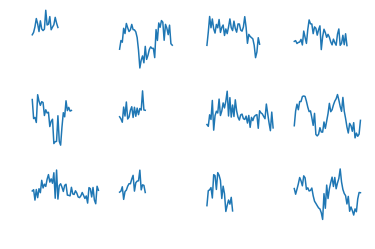

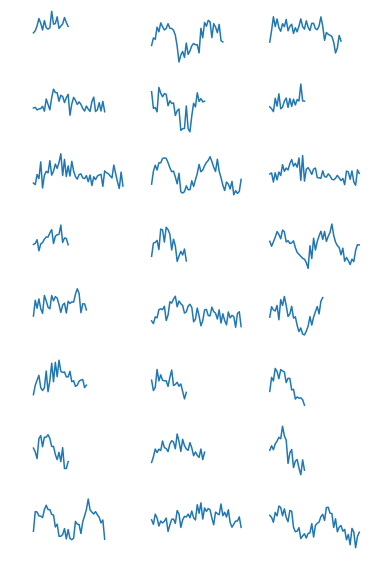

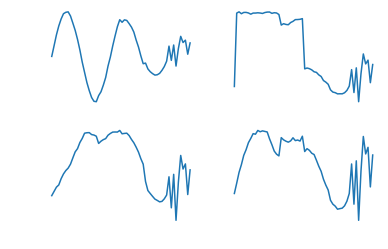

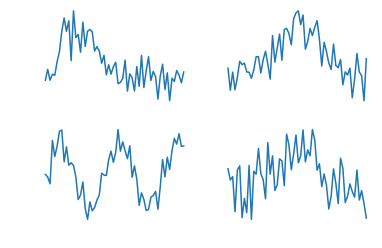

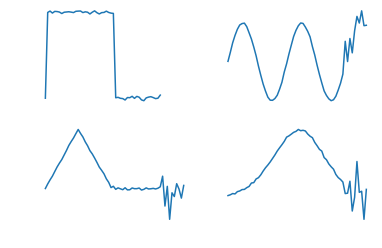

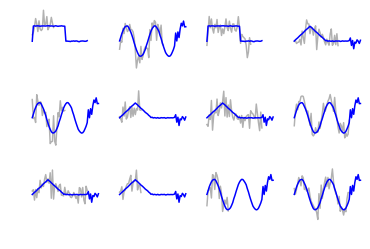

In [13]:
missing_samples = (m-5)/m
missing_entries = (T-20)/T
A_missing, to_remove = remove_entries(A, missing_samples, missing_entries, sections=4)
C_replace = cluster_substitute_mean(A_missing)
C_exclude = cluster_exclude_missing(A_missing)
C_glrm, labels = cluster_pivot(A_missing, to_remove)
A_hat = impute_missing(A_missing, C_glrm, labels)

## Signal table

In [14]:
from sklearn.datasets import make_blobs
from mpl_toolkits.mplot3d import Axes3D

def generate_additional_features(A, labels, d):
    np.random.seed(0)
    m, T = A.shape
    A_sorted = A[np.argsort(labels), :]
    B, blob_labels = make_blobs(n_samples = [len(labels[labels==0]),
                    len(labels[labels==1]), 
                    len(labels[labels==2]), 
                    len(labels[labels==3])], n_features=d, random_state=1, center_box=(5,25))
    B_sorted = B[np.argsort(blob_labels), :]
    D = np.hstack((B_sorted, A_sorted))
    np.random.shuffle(D)
    
    f = plt.figure()
    ax = f.add_subplot(111, projection='3d')
    ax.scatter(B[:,0], B[:,1], B[:,2])
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    f.savefig("figures/table_features", dpi=600) 
    
    f, axes = plt.subplots(nrows=3, ncols=4, sharex=True, sharey=True)
    for i in range(3):
        for j in range(4):
            if 4*i+j not in to_remove:
                axes[i,j].plot(D[4*i+j, d:])
            axes[i,j].axis('off')
            axes[i,j].set_title("("+",".join("{0:0.0f}".format(D[4*i+j,l]) for l in range(d))+")")
    f.savefig("figures/table_glimpse", dpi=600) 
    return D

In [15]:
def cluster_table(D, d):
    k = 4
    m = D.shape[0]
    to_remove = list(np.where(np.isnan(D[:,d+1]))[0])
    to_keep = list(set(range(m)).difference(to_remove))
    
    F = D.copy()
    F[:,d:] = D[:,d:].cumsum(axis=1)
    
    # cluster those for which values are provided
    model = KMeans(n_clusters=4, random_state=0)
    model.fit(F[to_keep,:])
    C = model.cluster_centers_
    C[:,d+1:] -= C[:,d:-1].copy()
    
    # use first d dimensions to assign messy samples to clusters
    data = np.tile(D[to_remove, :d], (k,1,1)).transpose((1,2,0))
    clusters = np.tile(C[:,:d], (len(to_remove),1,1)).transpose((0,2,1))
    labels = np.argmin(np.linalg.norm(data-clusters, axis=1), axis=1)
    
    all_labels = np.zeros(m)
    all_labels[to_remove] = labels
    all_labels[to_keep] = model.labels_
    
    f, axes = plt.subplots(nrows=2, ncols=2)
    for i in range(2):
        for j in range(2):
            axes[i,j].plot(C[2*i+j, d:])
            axes[i,j].axis('off')
    f.savefig("figures/table_experiment", dpi=600)
    return C, all_labels.astype(int)

In [16]:
def impute_table(A, C, labels, random_seed=1):
    B = np.vstack(C[l,:] for l in labels)
    
    f, axes = plt.subplots(nrows=3, ncols=4, sharex=True, sharey=True)
    for i in range(3):
        for j in range(4):
            axes[i,j].plot(A[4*i+j, d:], alpha=0.3, color='k')
            axes[i,j].plot(B[4*i+j, d:], alpha=1.0, color='b')
            axes[i,j].set_title("("+",".join("{0:0.0f}".format(A[4*i+j,l]) for l in range(d))+")")
            axes[i,j].axis('off')
    f.savefig("figures/table_glimpse_impute", dpi=600) 

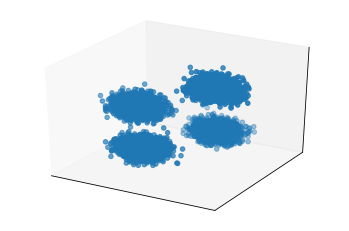

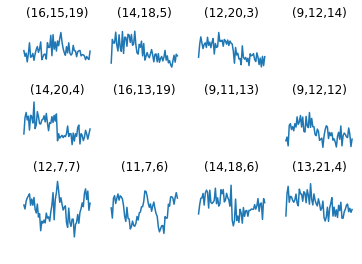

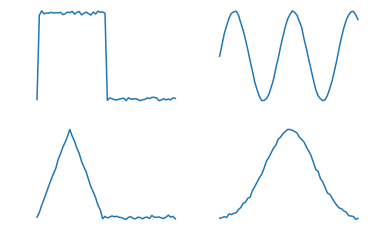

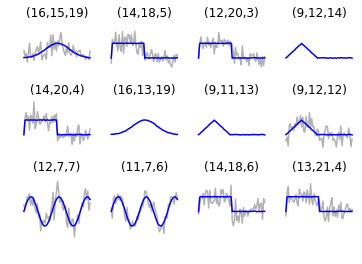

In [17]:
d = 3
A_missing_table = A.copy()
missing_series = 0.5
A_missing_table[np.random.choice(range(m), size=int(missing_series*m), replace=False), :] = np.nan
D = generate_additional_features(A_missing_table, labels, d)
C, table_labels = cluster_table(D, d)
impute_table(D, C, table_labels)